## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import pickle
%matplotlib qt
%matplotlib inline

'''
Camera class is used to:
    - calculate calibration parameters for the camera based on a set of calibration images
    - store calibration parameters for later use
    - read in calibration parameters to save on processing time
    - undistort an image using calibration parameters, for later processing
    - undistort a set of test images using calibration parameters, for demo purposes
'''
class Camera():
    def __init__(self):
        # camera calibration parameters
        self.mtx = []
        self.dist = []

    # calculate camera calibration parameters based on the calibration images
    def calculate_calibration_parameters(self):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob('camera_cal/calibration*.jpg')

        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            img_size = (img.shape[1], img.shape[0])

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)

                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                cv2.imshow('img',img)
                cv2.waitKey(500)

        cv2.destroyAllWindows()

        if len(objpoints) & len(imgpoints):
            # Do camera calibration given object points and image points
            ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

        # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
        dist_pickle = {}
        dist_pickle["mtx"] = self.mtx
        dist_pickle["dist"] = self.dist
        pickle.dump( dist_pickle, open( "camera_cal/camera_calibration_parameters.p", "wb" ) )

        print("Created new calibration parameters: mtx=", self.mtx, "; dist=", self.dist)


    # Read in the saved calibration parameters
    def read_calibration_parameters(self):
        calibration_file_path = "camera_cal/camera_calibration_parameters.p"
        if os.path.isfile(calibration_file_path):
            dist_pickle = pickle.load( open( calibration_file_path, "rb" ) )
            self.mtx = dist_pickle["mtx"]
            self.dist = dist_pickle["dist"]

            print("Loaded calibration parameters: mtx=", self.mtx, "; dist=", self.dist)


    # read saved calibration parameters or calculate based on the calibration images
    def initialize_calibration_parameters(self):
        # try to read calibration parameters saved before (speed up processing during development)
        self.read_calibration_parameters()

        # if saved camera calibration parameters were not found - try to calibrate camera
        if not (len(self.mtx) & len(self.dist)):
            self.calculate_calibration_parameters()


    # if camera calibration parameters are initiaized properly - undistort test images
    def undistort_test_images(self):
        if len(self.mtx) & len(self.dist):

            in_folder = "test_images/"
            out_folder = "output_images/"

            if not os.path.exists(out_folder):
                os.makedirs(out_folder)

            source_files = os.listdir(in_folder)

            # Read sample images, undistort and write to the output folder
            for source_file in source_files:

                source_path = in_folder + source_file
                img = cv2.imread(source_path)

                undistorted = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

                result_path = out_folder + source_file
                print("result_path=", result_path);
                cv2.imwrite(result_path, undistorted)

                # Draw and display undistorted image
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
                f.tight_layout()
                ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
                ax1.set_title('Original Image', fontsize=50)
                ax2.imshow(cv2.cvtColor(undistorted,cv2.COLOR_BGR2RGB))
                ax2.set_title('Undistorted Image', fontsize=50)
                plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
                plt.show()

    # undistort image using the camera calibration parameters
    def undistort_image(self, image):
        if len(self.mtx) & len(self.dist):
            return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
                



## And so on and so forth...

In [22]:
def debug_show_images(img1, title1, img2, title2, cmap1=None, cmap2=None):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1, cmap=cmap1)
    ax1.set_title(title1, fontsize=50)
    ax1.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=True,
                     bottom=True, top=True, left=True, right=True)
    ax2.imshow(img2, cmap=cmap2)
    ax2.set_title(title2, fontsize=50)
    ax2.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=True,
                     bottom=True, top=True, left=True, right=True)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()


In [3]:
class BinaryImage():
    def __init__(self):
        pass

In [4]:
# Calculate directional gradient and apply threshold
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    # grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # derivative
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # absolute value
    abs_sobel = np.absolute(sobel)
    
    # scale to 0-255
    abs_sobel_max = np.max(abs_sobel)
    abs_sobel = np.uint8(255*abs_sobel/abs_sobel_max)
    
    # apply threshold
    binary_output = np.zeros_like(abs_sobel)
    binary_output[(abs_sobel >= thresh[0]) & (abs_sobel <= thresh[1])] = 1
    
    # display the result
    #debug_show_images(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), 'Original Image', binary_output, 'Thresholded Gradient', cmap2 = 'gray')
    
    return binary_output

# Calculate gradient magnitude and apply threshold
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    
    # grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # derivative
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # magnitude
    sobel = np.zeros_like(sobel_x)
    sobel = (sobel_x**2 + sobel_y**2)**(1/2.0)
    
    # scale to 0-255
    sobel_max = np.max(sobel)
    sobel = np.uint8(255*sobel/sobel_max)
    
    # apply threshold
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel >= mag_thresh[0]) & (sobel <= mag_thresh[1])] = 1

    # display the result
    #debug_show_images(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), 'Original Image', binary_output, 'Thresholded Magnitude', cmap2 = 'gray')
    
    return binary_output

# Calculate gradient direction and apply threshold
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    
    # grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # derivative
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # absolute value and direction of the gradient
    grad_direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    
    # apply threshold
    binary_output = np.zeros_like(grad_direction)
    binary_output[(grad_direction >= thresh[0]) & (grad_direction <= thresh[1])] = 1
    
    # display the result
    #debug_show_images(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), 'Original Image', binary_output, 'Thresholded Grad. Dir.', cmap2 = 'gray')
    
    return binary_output


# calculate binary image based on different gradient thresholds (absolute, magnitude, direction)
def gradient_threshold(image):
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # display the result
    #debug_show_images(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), 'Original Image', combined, 'Combined Grad.-Thresh. Image', cmap2 = 'gray')
    
    return combined


In [5]:
def colour_threshold(image, s_thresh=(170, 255), sx_thresh=(20, 100)):
    #image = np.copy(image)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x on luminance channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary


In [6]:
def combined_threshold(gradient_binary, colour_binary):
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gradient_binary)
    combined_binary[(gradient_binary == 1) | (colour_binary == 1)] = 1
    return combined_binary


In [42]:
def perspective_transform(image):
    
    # calculate region of interest
    ysize = image.shape[0]
    xsize = image.shape[1]

    near_distance = ysize-1
    far_distance = ysize*0.645

    left_bottom = [0+70, near_distance]
    right_bottom = [xsize-1-70, near_distance]

    left_apex = [xsize/2-89, far_distance]
    right_apex = [xsize/2-1+89, far_distance]

    src = np.float32(
        [left_bottom,
        left_apex,
        right_apex,
        right_bottom])
    dst = np.float32(
        [[0, ysize-1],
        [0, 0],
        [xsize-1, 0],
        [xsize-1, ysize-1]])
    
    # draw source region
    #for i in range(0, len(src)-1):
    #    cv2.line(image, (src[i][0], src[i][1]), (src[i+1][0], src[i+1][1]), [255, 0, 0], 2)
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (xsize, ysize), flags=cv2.INTER_LINEAR)
    
    return warped


In [50]:
# Define a class to receive the characteristics of each line detection
class Line():
    
    def __init__(self):
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
        
        # Parameters for the sliding window search
        # The threshold for the histogram value
        self.histogram_threshold = 50
        # The number of sliding windows
        self.nwindows = 9
        # The width of the windows +/- margin
        self.margin_sliding_window = 100
        # Minimum number of pixels found to recenter window
        self.minpix = 50
        
        # Parameters for the search around polynomial
        # The width of the margin around the previous polynomial to search
        self.margin_polynomial_search = 100
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension


        
    def measure_curvature_pixels(self, y_eval):
        '''
        Calculates the curvature of polynomial functions in pixels.
        '''
        curverad = 0
        
        if self.detected:
            # Calculate radius of curvature
            curverad = ((1 + (2*self.best_fit[0]*y_eval + self.best_fit[1])**2)**1.5) / np.abs(2*self.best_fit[0])

        return curverad

    def measure_curvature_real(self, y_eval):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
        self.radius_of_curvature = 0

        if self.detected:
            y = y_eval * ym_per_pix
            a = self.best_fit[0] * xm_per_pix / (ym_per_pix ** 2)
            b = self.best_fit[1] * (xm_per_pix / ym_per_pix)

            # Calculate radius of curvature
            self.radius_of_curvature = ((1 + (2*a*y + b)**2)**1.5) / np.abs(2*a)

        return self.radius_of_curvature

    # find lane pixels and color them
    def find_lane_pixels_histohramm_sliding_window(self, binary_warped):

        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        #plt.plot(histogram)
        #plt.show()
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        #print("midpoint=", midpoint, "; leftx_base=", leftx_base, "; rightx_base=", rightx_base, "; histogram[leftx_base]=", histogram[leftx_base], "; histogram[rightx_base]=", histogram[rightx_base])
        
        # check if the histogram values make sense
        if histogram[leftx_base] < self.histogram_threshold or histogram[rightx_base] < self.histogram_threshold:
            self.detected = False
            return [], [], [], [], out_img

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//self.nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        #print(nonzeroy, nonzerox)
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - self.margin_sliding_window  # Update this
            win_xleft_high = leftx_current + self.margin_sliding_window  # Update this
            win_xright_low = rightx_current - self.margin_sliding_window  # Update this
            win_xright_high = rightx_current + self.margin_sliding_window  # Update this
            #print("win_y_low=", win_y_low, "win_y_high=", win_y_high, "win_xleft_low=", win_xleft_low, "win_xleft_high=", win_xleft_high, "win_xright_low=", win_xright_low, "win_xright_high=", win_xright_high)

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

            #print(len(nonzeroy), len(nonzerox))

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                    (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                    (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            ### TO-DO: If you found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            #print(len(good_left_inds), len(good_right_inds))
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        ## Visualization ##
        # Color the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        self.detected = True
        return leftx, lefty, rightx, righty, out_img

    # find lane pixels and color them
    def find_lane_pixels_search_around_polynomial(self, binary_warped):

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        #left_lane_inds = None
        #right_lane_inds = None
        #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        ploty = nonzeroy
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_lane_inds = ((nonzerox >= (left_fitx-self.margin_polynomial_search)) & (nonzerox < (left_fitx+self.margin_polynomial_search)))
        right_lane_inds = ((nonzerox >= right_fitx-self.margin_polynomial_search) & (nonzerox < right_fitx+self.margin_polynomial_search))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        ## Visualization ##
        # Create an image to draw on
        out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
        # Color the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        self.detected = True
        return leftx, lefty, rightx, righty, out_img

    def fit_polynomial(self, img_shape, leftx, lefty, rightx, righty):

        ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty, leftx, 2)
        #print(leftx, lefty, left_fit)
        right_fit = np.polyfit(righty, rightx, 2)
        #print(rightx, righty, right_fit)

        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            self.detected = True
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
            self.detected = False

        return left_fitx, right_fitx, ploty

    def visualize_lines(self, out_img, left_fitx, right_fitx, ploty):
        # Plot the polynomial lines onto the image
        # Generate a polygon to illustrate the polinomial found
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-2, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+2, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-2, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+2, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(out_img, np.int_([left_line_pts]), (255,255, 0))
        cv2.fillPoly(out_img, np.int_([right_line_pts]), (255,255, 0))

        return out_img

    def visualize_line_search_area(self, out_img, left_fitx, right_fitx, ploty):
        ## Visualization ##
        # Create an image to show the selection window
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-self.margin_polynomial_search, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+self.margin_polynomial_search, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-self.margin_polynomial_search, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+self.margin_polynomial_search, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        return result

    def find_lane_lines(self, binary_warped):

        # if lane was detected in the previous image - try to search around polynomial
        if self.detected:
            
            # find pixels along the polynomial
            leftx, lefty, rightx, righty, out_img = self.find_lane_pixels_search_around_polynomial(binary_warped)
            
            # if pixels were found
            if self.detected:
                
                # fit polynomial
                left_fitx, right_fitx, ploty = self.fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)

                # if it worked out with this image - visualize the result
                if self.detected:
                    # visualize polynomial and additional info
                    self.visualize_line_search_area(out_img, left_fitx, right_fitx, ploty)
                    self.visualize_lines(out_img, left_fitx, right_fitx, ploty)
            
        # if there's no detection from the previous frame OR detection based on the previous frame failed - try sliding window
        if not self.detected:
            
            # find pixels using histogram and sliding window approach
            leftx, lefty, rightx, righty, out_img = self.find_lane_pixels_histohramm_sliding_window(binary_warped)

            # if pixels were found
            if self.detected:
                
                # fit polynomial
                left_fitx, right_fitx, ploty = self.fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)

                # if it worked out with this image - visualize the result
                if self.detected:
                    # visualize polynomial and additional info
                    self.visualize_lines(out_img, left_fitx, right_fitx, ploty)

        # if detection failed - then skip curvature measurement
        ## TODO remove this comment after refactoring, calculate curvature
        #if not self.detected:
            return out_img
        
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)

        # measure and display curvature radius in pixels
        curvature_left = self.measure_curvature_pixels(y_eval)
        curvature_right = self.measure_curvature_pixels(y_eval)
        print('curvature radius left = ', curvature_left, 'px', '; curvature radius right = ', curvature_right, 'px')

        # measure and display curvature radius in meters
        curvature_left = self.measure_curvature_real(y_eval)
        curvature_right = self.measure_curvature_real(y_eval)
        print('curvature radius left = ', curvature_left, 'm', '; curvature radius right = ', curvature_right, 'm')

        return out_img
    

Loaded calibration parameters: mtx= [[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] ; dist= [[-0.24688775 -0.02373133 -0.00109842  0.00035108 -0.00258571]]
Reading from source_path= test_images/straight_lines1.jpg
Writing to result_path= output_images/undistorted_straight_lines1.jpg
Writing to result_path= output_images/threholded_straight_lines1.jpg


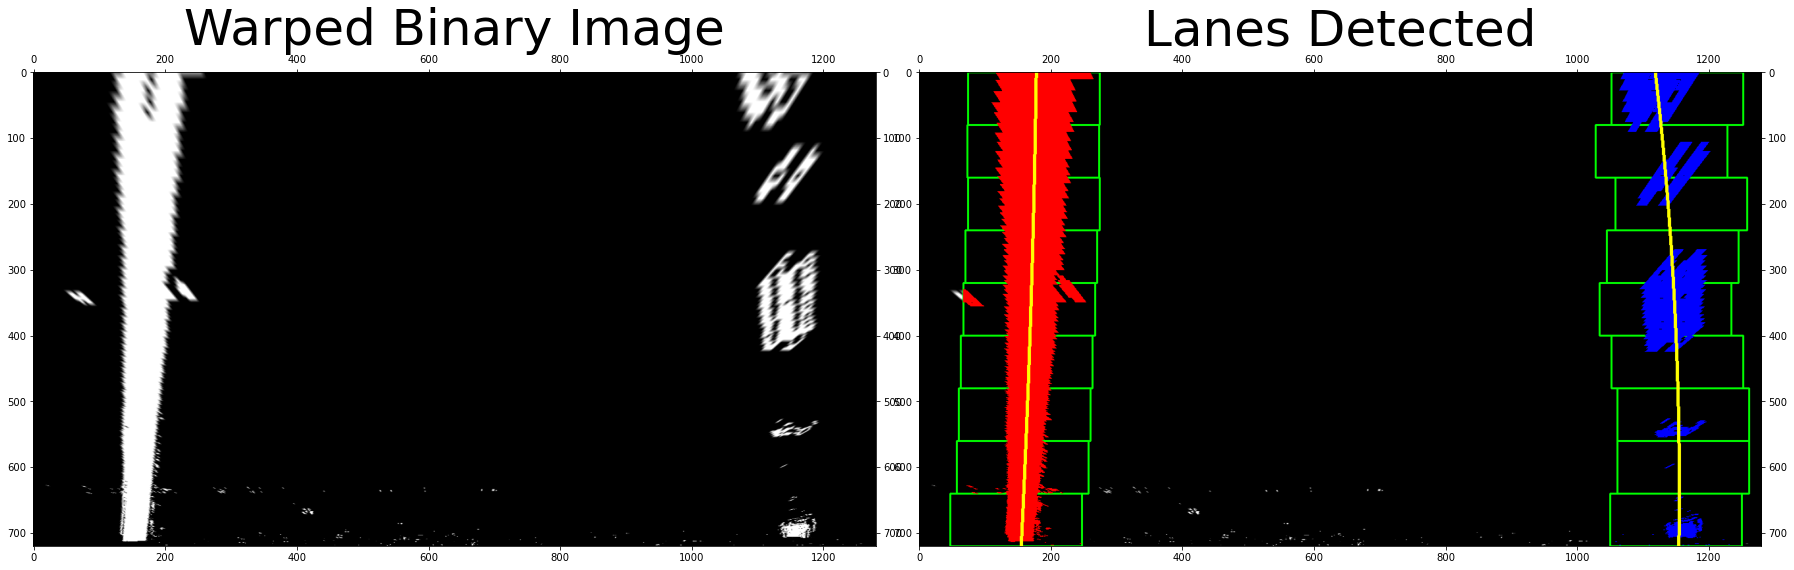

Reading from source_path= test_images/straight_lines2.jpg
Writing to result_path= output_images/undistorted_straight_lines2.jpg
Writing to result_path= output_images/threholded_straight_lines2.jpg


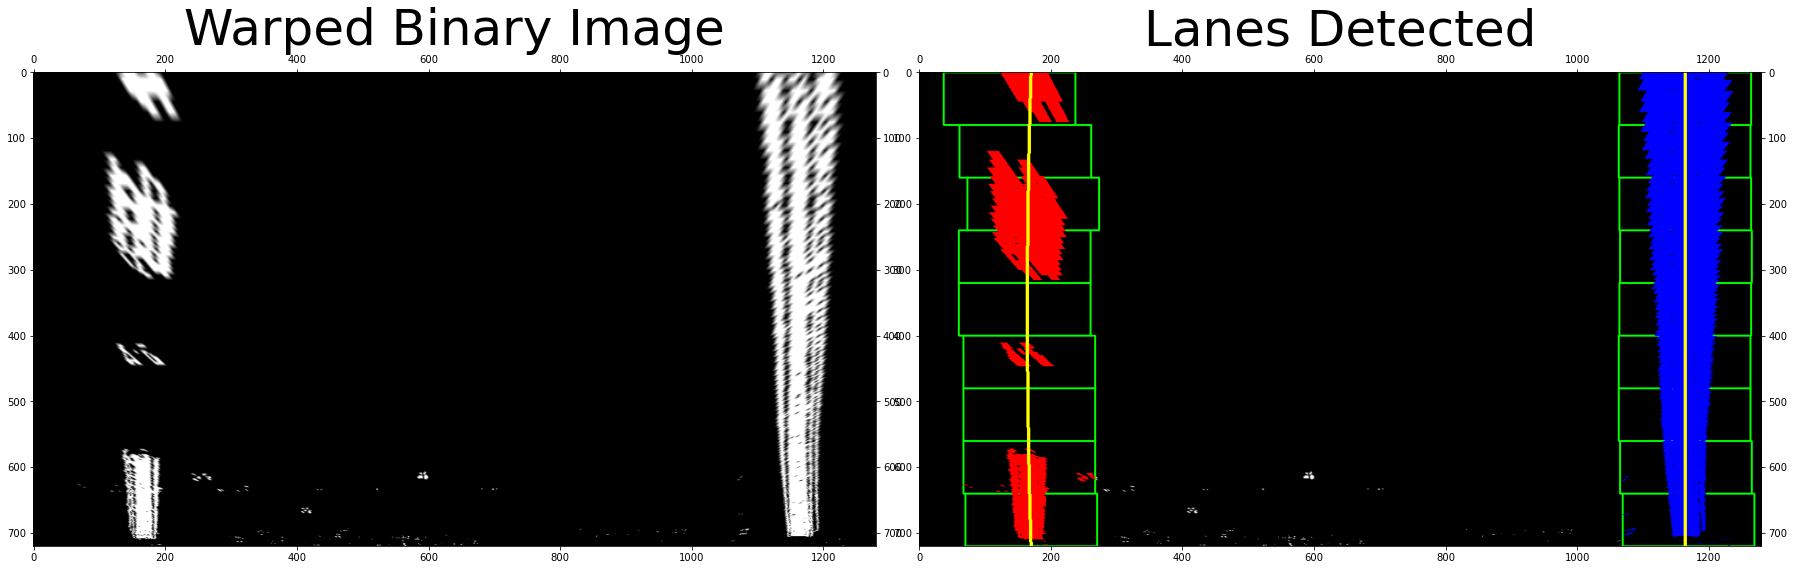

Reading from source_path= test_images/test1.jpg
Writing to result_path= output_images/undistorted_test1.jpg
Writing to result_path= output_images/threholded_test1.jpg


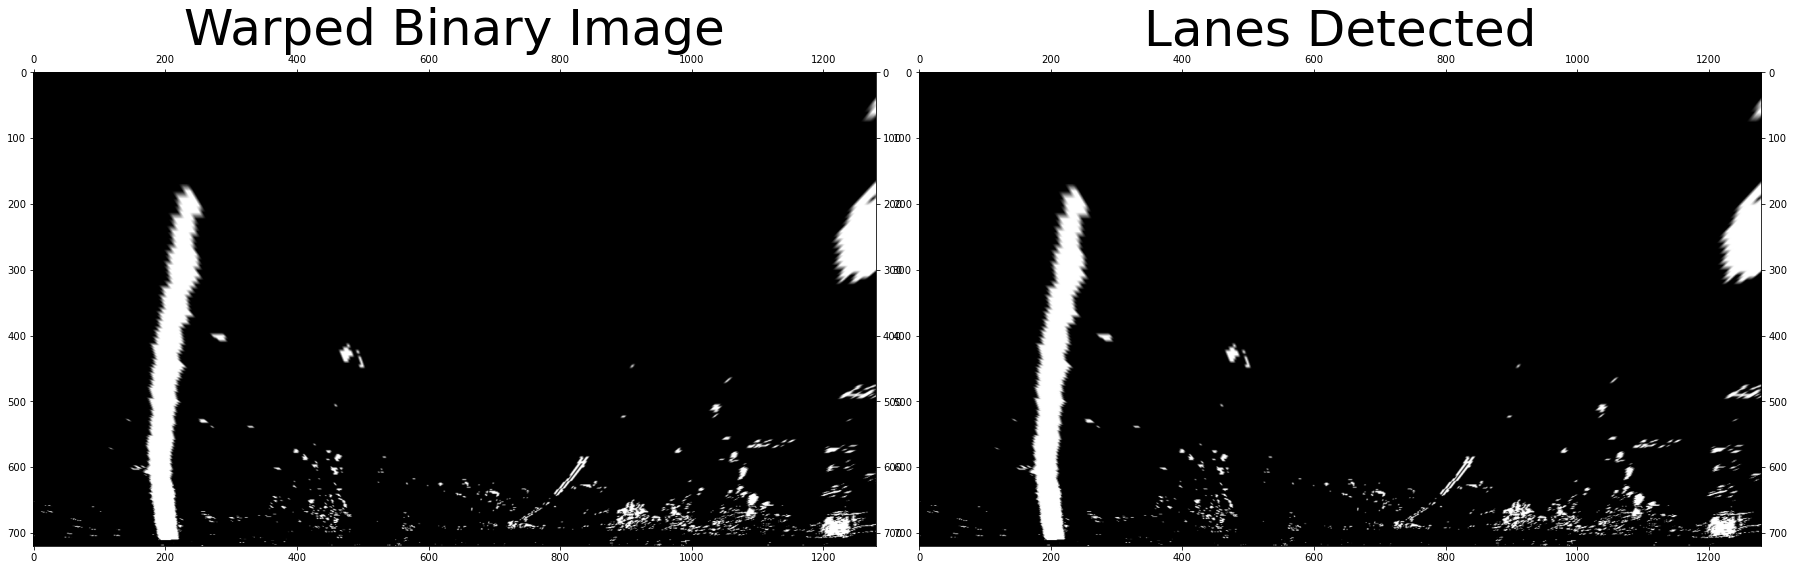

Reading from source_path= test_images/test2.jpg
Writing to result_path= output_images/undistorted_test2.jpg
Writing to result_path= output_images/threholded_test2.jpg


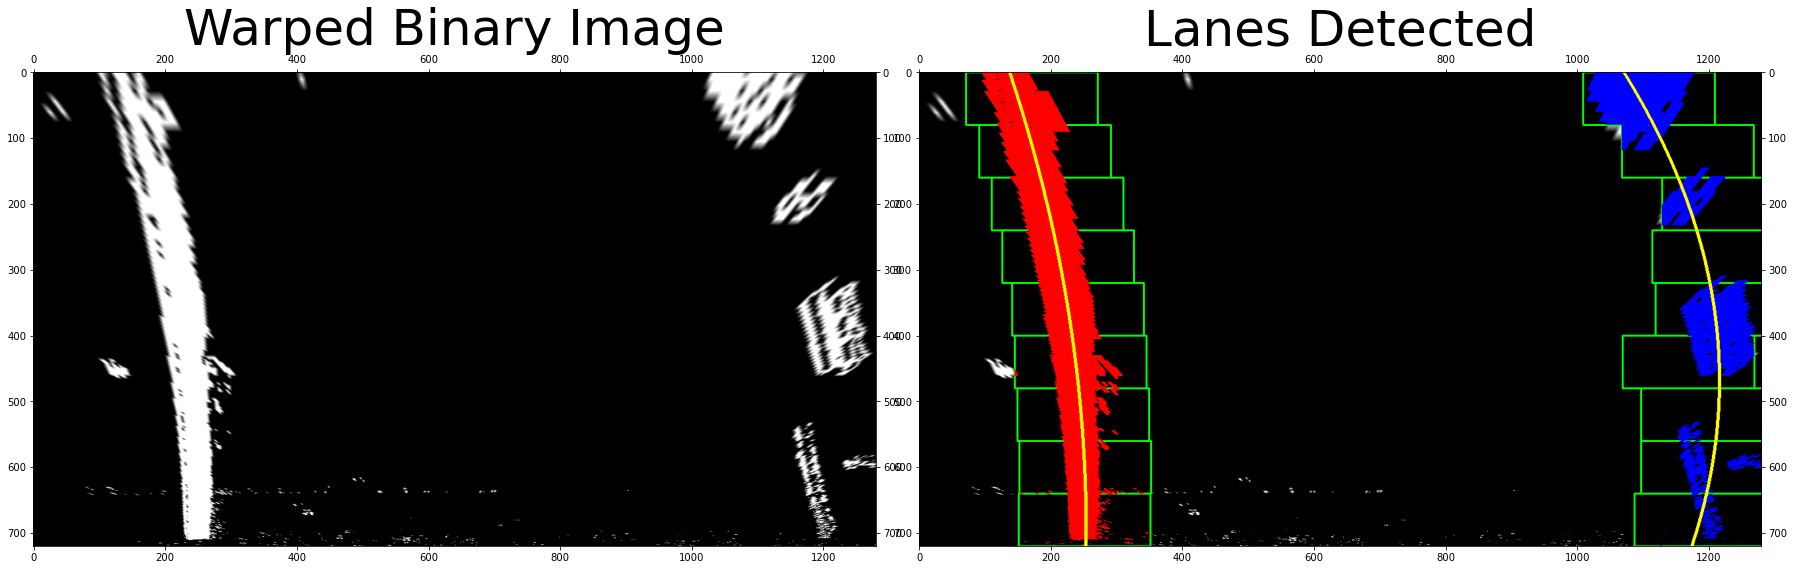

Reading from source_path= test_images/test3.jpg
Writing to result_path= output_images/undistorted_test3.jpg
Writing to result_path= output_images/threholded_test3.jpg


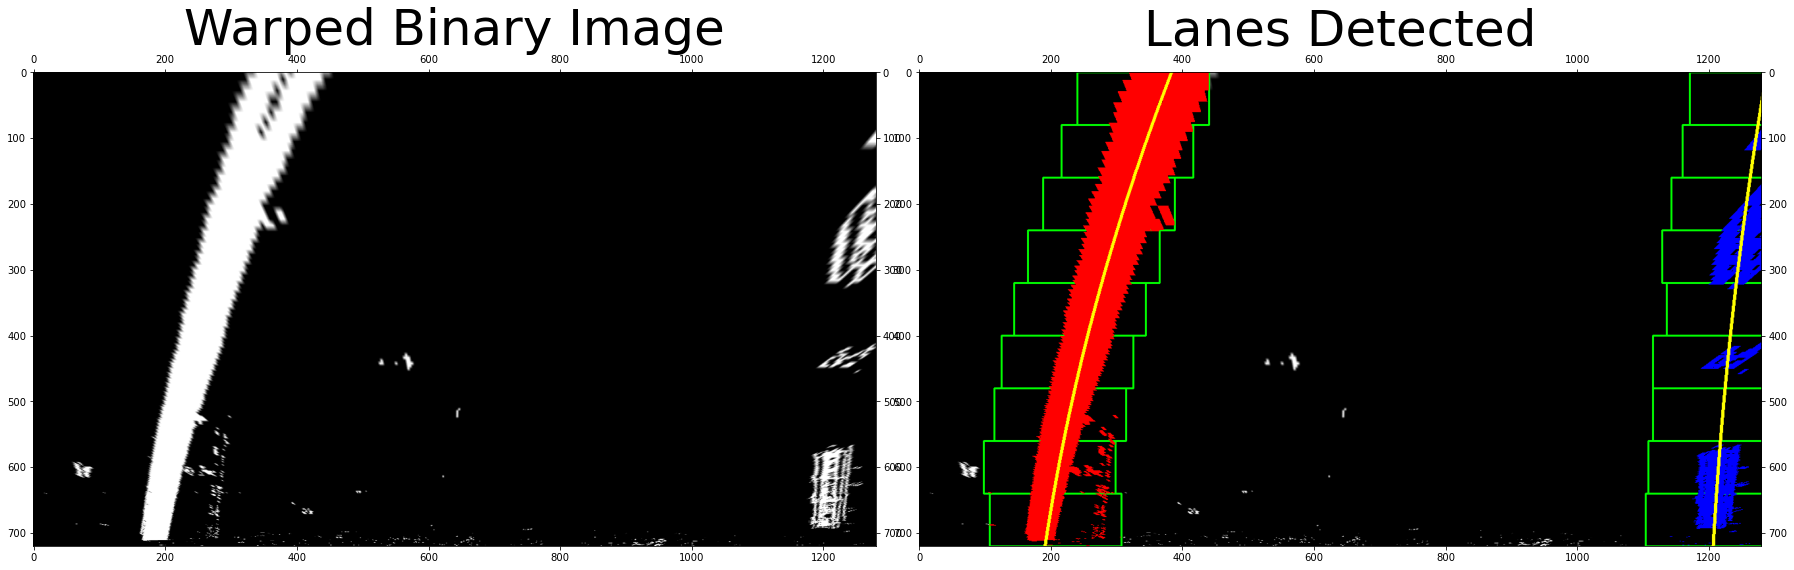

Reading from source_path= test_images/test4.jpg
Writing to result_path= output_images/undistorted_test4.jpg
Writing to result_path= output_images/threholded_test4.jpg


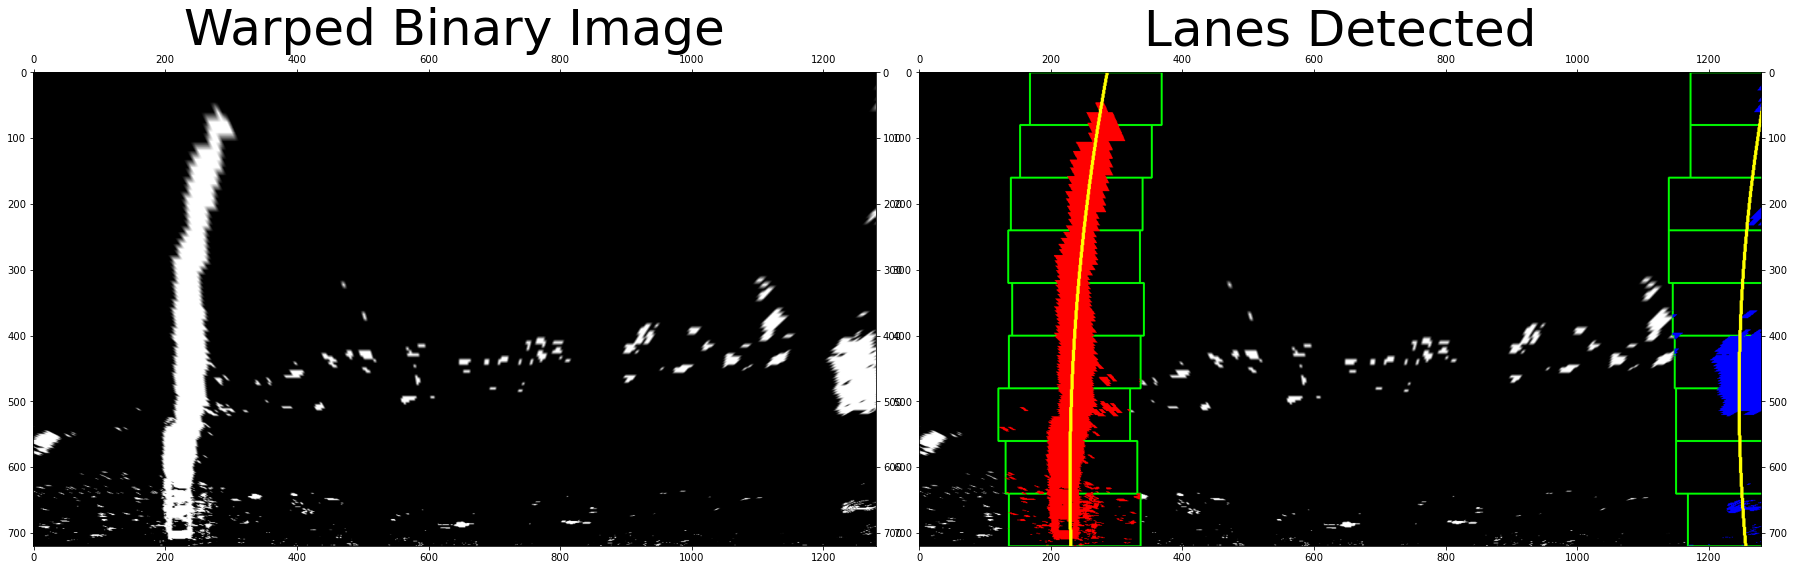

Reading from source_path= test_images/test5.jpg
Writing to result_path= output_images/undistorted_test5.jpg
Writing to result_path= output_images/threholded_test5.jpg


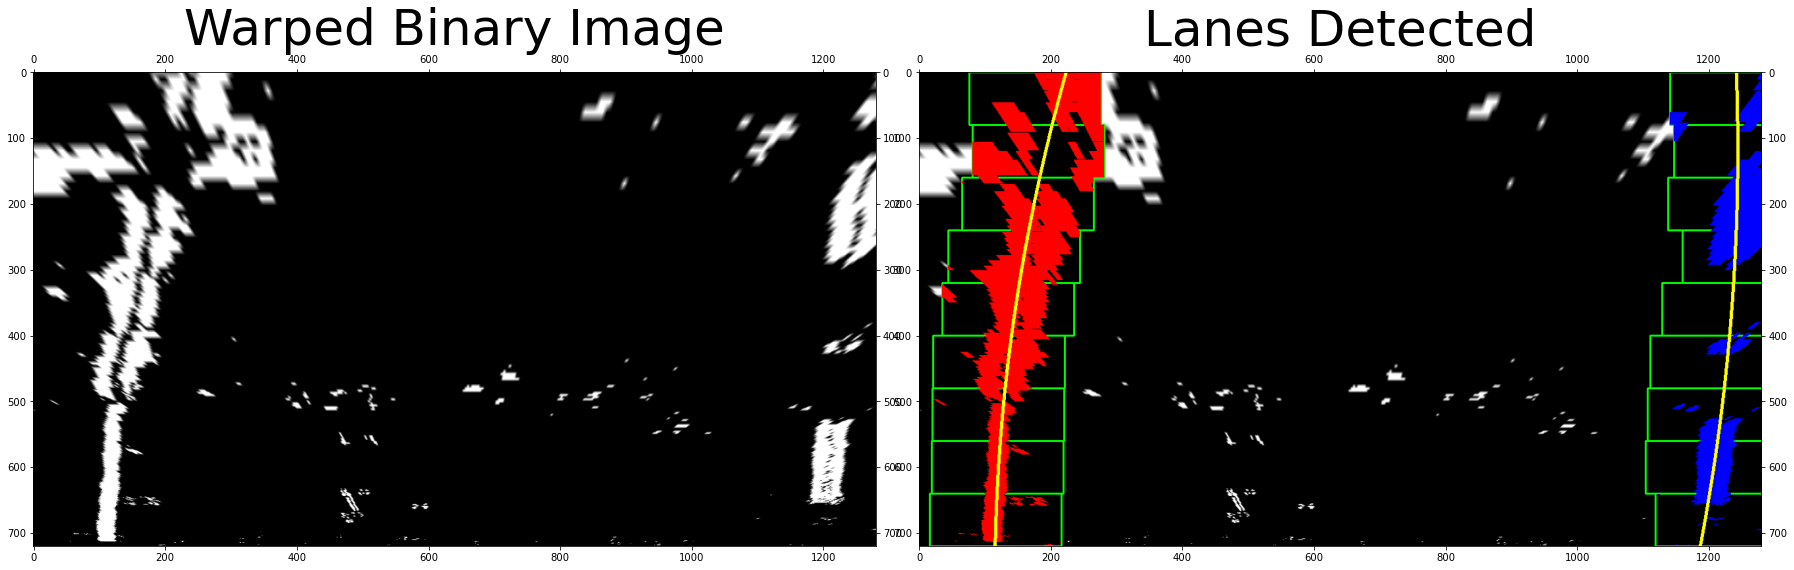

Reading from source_path= test_images/test6.jpg
Writing to result_path= output_images/undistorted_test6.jpg
Writing to result_path= output_images/threholded_test6.jpg


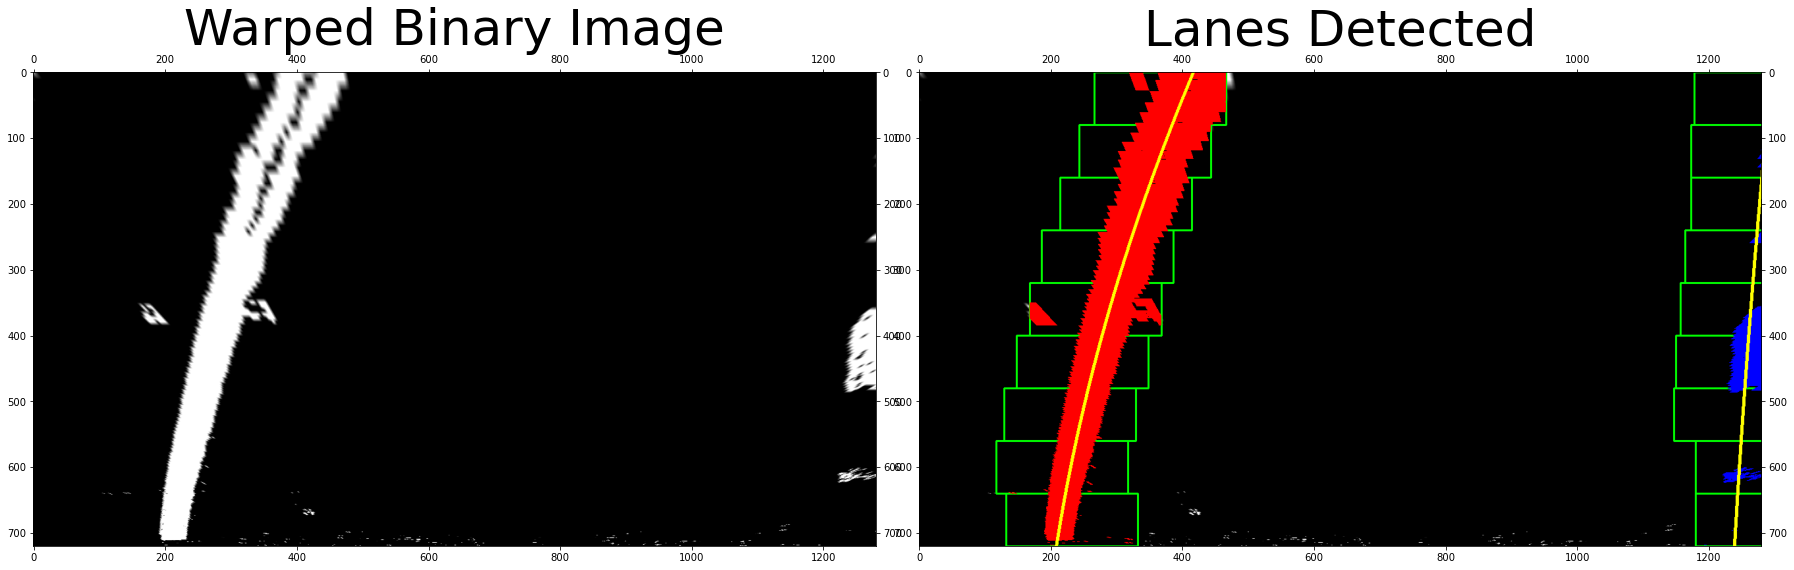

In [51]:
camera = Camera()
camera.initialize_calibration_parameters()

in_folder = "test_images/"
out_folder = "output_images/"

if not os.path.exists(out_folder):
    os.makedirs(out_folder)

source_files = os.listdir(in_folder)

# Read and process sample images
for source_file in source_files:

    # read test image in
    source_path = in_folder + source_file
    print("Reading from source_path=", source_path);
    img = cv2.imread(source_path)

    # undistort according to the camera calibration parameters
    undistorted = camera.undistort_image(img)
    #debug_show_images(cv2.cvtColor(img,cv2.COLOR_BGR2RGB), 'Original Image', cv2.cvtColor(undistorted,cv2.COLOR_BGR2RGB), 'Undistorted Image')

    # write undostorted image to output folder, if needed
    result_path = out_folder + 'undistorted_' + source_file
    print("Writing to result_path=", result_path);
    cv2.imwrite(result_path, undistorted)
    
    # find threholded binary image using gradients
    thresholded_grad = gradient_threshold(undistorted)
    #debug_show_images(cv2.cvtColor(undistorted,cv2.COLOR_BGR2RGB), 'Undistorted Image', thresholded_grad, 'Thresholded by Gradients', cmap2 = 'gray')
    
    # another try with colour transformation and gradient
    thresholded_col = colour_threshold(undistorted)
    #debug_show_images(cv2.cvtColor(undistorted,cv2.COLOR_BGR2RGB), 'Undistorted Image', thresholded_col, 'Thresholded by Colour', cmap2 = 'gray')
    
    # combine into a single threholded binary image
    combined_binary = combined_threshold(thresholded_grad, thresholded_col)
    #debug_show_images(cv2.cvtColor(undistorted,cv2.COLOR_BGR2RGB), 'Undistorted Image', combined_binary, 'Thresholded Image', cmap2 = 'gray')

    # write threholded image to output folder, if needed
    result_path = out_folder + 'threholded_' + source_file
    print("Writing to result_path=", result_path);
    cv2.imwrite(result_path, combined_binary * 255)
    
    warped_image = perspective_transform(undistorted)
    #debug_show_images(cv2.cvtColor(undistorted,cv2.COLOR_BGR2RGB), 'Undistorted Image', cv2.cvtColor(warped_image,cv2.COLOR_BGR2RGB), 'Warped Image')

    warped_binary = perspective_transform(combined_binary)
    #debug_show_images(combined_binary, 'Thresholded Image', warped_binary * 255, 'Warped Binary Image', cmap1 = 'gray', cmap2 = 'gray')


    line = Line()
    out_img = line.find_lane_lines(warped_binary)
    debug_show_images(warped_binary * 255, 'Warped Binary Image', out_img.astype(int), 'Lanes Detected', cmap1 = 'gray')
    
    #break